In [1]:
from sys import stdout
from os.path import join, isdir, isfile, exists
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
import scipy.integrate as integrate
from random import sample
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import time
from scipy import stats

In [2]:
washing_machines = pd.read_hdf('./washing_machines.h5')
dish_washers = pd.read_hdf('./dish_washers.h5')
tumble_dryers = pd.read_hdf('./tumble_dryers.h5')

In [3]:
# ADD TO LIB
def getMinMaxDates(df):
    # find the dates that exist for all measurements
    maxdate = df.index.get_level_values('Unix').max()
    mindate = df.index.get_level_values('Unix').min()
    # for all buildings get the common denominator for min and max dates
    for i in np.unique(df.index.get_level_values('building')):
        mask = df.index.get_level_values('building') == i
        if (df.loc[mask].index.get_level_values('Unix').max()) < maxdate:
            maxdate = df.loc[mask].index.get_level_values('Unix').max()
        if (df.loc[mask].index.get_level_values('Unix').min()) > mindate:
            mindate = df.loc[mask].index.get_level_values('Unix').min()
    return (mindate, maxdate)

(mindate1,maxdate1) = getMinMaxDates(washing_machines)
(mindate2,maxdate2) = getMinMaxDates(dish_washers)
(mindate3,maxdate3) = getMinMaxDates(tumble_dryers)
print(mindate1, maxdate1)
print(mindate2, maxdate2)
print(mindate3, maxdate3)
mindate = max(mindate1, mindate2, mindate3)
maxdate = min(maxdate1, maxdate2, maxdate3)
print(mindate, maxdate)

2014-06-03 11:30:00 2015-05-10 23:30:00
2014-06-03 11:30:00 2015-05-22 15:15:00
2014-03-20 12:00:00 2015-05-10 23:30:00
2014-06-03 11:30:00 2015-05-10 23:30:00


In [4]:
timedelta = maxdate-mindate
trainset = mindate + timedelta/2

In [5]:
from datetime import date
delta = maxdate - trainset
print(delta.days)

170


In [6]:
def on_times(appliance):
    """
        Parameters
        ----------
        appliance = a dataframe of an appliance witn an 'active' column

        Returns
        A dataframe with a datetime index and a column duration.
        Index is when the appliance started and duration the amount of slots the appliance was on (power>20watt).

    """
    records = len(appliance)
    on_dur = pd.DataFrame(columns=['duration'])
    i = 0
    # TODO(kyrcha): possible optimization with matrix
    while (i < records):
        j = 0
        if appliance['active'].values[i] > 50:
            # to parakatw to evala giati evgaze proeidopoihsh gia nan pou nomizw den isxye kiolas
            # todo: check if nan exist.
            np.warnings.filterwarnings('ignore')
            #αν δεν είναι το τελευταιο στοιχείο του πίνακα γιατί πετούσε έρρορ
            while appliance['active'].values[i + j] > 50:
                if j == 0:
                    on_time = appliance.index.get_level_values('Unix')[i]
                j = j + 1
                if ((i + j) == records):
                    break
            on_dur.loc[on_time] = j
            i = i + j -1
        i = i + 1
    return on_dur

In [7]:
# how many days per average is the washing machine open?
idx = pd.IndexSlice
for i in np.unique(dish_washers.index.get_level_values('building')):
    mask = dish_washers.index.get_level_values('building') == i
    app = dish_washers.loc[idx[mask, :, mindate:maxdate]]
    #print(on_times(app).index.get_level_values)
    print(f"Building: {i}")
    print(f"Days open (from the 168 days in total): {(len(np.unique(on_times(app).index.date)) * 100.0)/len(np.unique(app.index.get_level_values('Unix').date)):.2f}%")

Building: 1
Days open (from the 168 days in total): 27.19%
Building: 2
Days open (from the 168 days in total): 75.44%
Building: 3
Days open (from the 168 days in total): 67.84%
Building: 5
Days open (from the 168 days in total): 66.96%
Building: 6
Days open (from the 168 days in total): 17.84%
Building: 7
Days open (from the 168 days in total): 79.82%
Building: 9
Days open (from the 168 days in total): 65.20%
Building: 10
Days open (from the 168 days in total): 73.98%
Building: 11
Days open (from the 168 days in total): 10.23%
Building: 13
Days open (from the 168 days in total): 39.77%
Building: 15
Days open (from the 168 days in total): 3.22%
Building: 16
Days open (from the 168 days in total): 59.06%
Building: 18
Days open (from the 168 days in total): 34.50%
Building: 20
Days open (from the 168 days in total): 32.46%
Building: 21
Days open (from the 168 days in total): 68.71%


In [8]:
print(i)
print(len(np.unique(app.index.get_level_values('Unix').date)))
print(len(np.unique(on_times(app).index.date)))

21
342
235


In [9]:
def weekday (appliance):
    '''

    Parameters

    appliance

    Returns
    probs = a list of probabilities for each day

    '''
    new_app = appliance
    on_app = on_times(new_app)

    if on_app.empty:
        print('The appliance was never on')
        probs = []
    else:
        on_app['weekday'] = on_app.index.weekday
        new_app['weekday'] = new_app.index.get_level_values('Unix').weekday
        # για όλες τις μέρε του εξεταζόμενου διαστήματος φτιάχνουμε ένα dataframe [φτιάχνω καινούρια dataframe γιατί δν κτλβαίνω τι γίνεται στα παλιά αν τα κάνεις πχ resample]
        final_app = new_app.groupby([pd.Grouper(level='Unix', freq='D')]).mean()
        # για όλες τις μέρες που άνοιξε στο εξεταζόμενο διάστημα φτιάχνουμε ένα dataframe
        final_on_app = on_app.groupby(on_app.index.date).mean()
        #   μετράμε πόσες μέρες από κάθε είδος μέρας υπάρχει σε κάθε ένα από τα δύο dataframe
        days_on = final_on_app['weekday'].value_counts().to_frame().sort_index()
        days_total = final_app['weekday'].value_counts().to_frame().sort_index()
        # Η πιθανότητα μιας να είναι ανοιχτή μια καθημερινή ημέρα σε σχέση με το να μην είναι
        each_day_on = []
        each_day_total = []
        probs = []
        name_days = np.array(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
        for i in range(0, 7):
            if i in days_on.index:
                each_day_on.append(days_on.loc[i]['weekday'])
                each_day_total.append(days_total.loc[i]['weekday'])
                #print("Number of ", name_days[i], "s the appliance was on: ", each_day_on[i], sep='')
                #print('Total number of ', name_days[i], 's ', each_day_total[i], sep='')
                probs.append(each_day_on[i] / each_day_total[i])
                #print('Probability P(', name_days[i], "_on) = ", probs[i], sep='')
            else:
                #print("The appliance didn't turn on on ", name_days[i], 's', sep='')
                each_day_on.append(0)
                each_day_total.append(days_total.loc[i]['weekday'])
                probs.append(0)
            i = i + 1
    return probs

In [10]:
def prob_time_new(appliance):
    '''

    Parameters
    ----------
    appliance = a dataframe of an appliance witn an 'active' column

    Returns
    a series of diffent start times & how many times they occured
    an array of the same thing

    '''
    #fig = plt.figure()
    #ax = fig.add_subplot(1,1,1)
    #fig.suptitle(name + ' time on', fontsize=16)
    new_app = appliance
    # check  mer
    if new_app.empty:
        print('The appliance was never on')
        ptonosx = []
    else:
        on_app = on_times(new_app)
        if len(on_app) > 1:
            #κάνω μια στηλη μόνο με τις ώρες από το Datatime index
            on_app['time'] = on_app.index.time
            #μου εβγαζε error αν εβαζα κατευθείαν το index στο GMM και γ αυτό έκανα όλο αυτό με τους πίνακες ώστε να φτάσω στο W
            Y = on_app['time'].index.to_list()
            X = []
            for i in range(0, len(Y)):
               X.append(Y[i].hour * 3600 + Y[i].minute * 60 + Y[i].second)
            fullX = X.copy()

            # need to plot these here...
            # do everything with  1 house in mind and plot

            # φτιάχνουμε ένα νέο population όπου αντί για 0-24h, θα απλώνεται σε -6h ως 30h,
            for i in range(0, len(fullX)):
                # προσθέτοντας τα samples που είναι στις ώρες 0-6 στις ώρες 24-30
                if (fullX[i] < 21600):
                    fullX.append(86400 + fullX[i])
                # προσθέτοντας τα samples που είναι στις ώρες 0-6 στις ώρες 24-30
                elif (fullX[i] > 64800):
                    fullX.append(fullX[i] - 86400)
            # μετακινούμε αυτό το νέο population σε 0-36h
            for i in range(0, len(fullX)):
                fullX[i] = fullX[i] + 21600
            fullXX = np.array(fullX)
            fullXX = fullXX.reshape(-1, 1)
            if fullXX.size < 10:
                # return empty array if data are not enough
                return []
            gmm = GaussianMixture(n_components=10, covariance_type='diag', reg_covar=100, n_init=5).fit(fullXX)
            x = np.arange(0, 129600, 1)
            x = x.reshape(-1, 1)
            p = np.exp(gmm.score_samples(x))
            # κρατάμε τις πιθανότητες από τις ώρες που μας ενδιαφέρουν όντως και κανονικοποιούμε
            ptonosx = p[21600:108000] / p[21600:108000].sum()

            #ax.plot(y,probability)
            #ax.hist(fullXX,bins=96,density=True)
            #ax.set_title(str(len(Y)) + ' times it was on', fontsize=12)
            #plt.show()
        else:
            print('The appliance was on 1 time')
            ptonosx = []
    return (ptonosx)

In [11]:
def prob_duration(appliance):
    """

    Parameters
    ----------
    appliance = a dataframe of an appliance
    name = the name of the appliance
    Returns
    a

    """
    idx = pd.IndexSlice
    new_app = appliance
    on_app = on_times(new_app)
    probs = on_app['duration'].value_counts(normalize=True).sort_index().to_frame()
    probs = probs.loc[idx[probs.index<96]] # keep one day's worth of duration...else next day
    #fig = plt.figure()
    #fig.suptitle(name + ' duration', fontsize=16)
    #ax = fig.add_subplot(1, 1, 1)
    #ax.bar(probs.index, probs)
    return probs

In [12]:
np.unique(washing_machines.index.get_level_values('building'))


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15, 16, 17, 18,
       19, 20, 21])

In [13]:
# ADD TO LIB
def train(df, start , end):
    prob_times = []
    prob_days = []
    prob_dur = []
    #train the machine
    idx = pd.IndexSlice
    dic = np.unique(df.index.get_level_values('building'))
    for i in dic:
        mask = df.index.get_level_values('building') == i
        prob_days.append(weekday(df.loc[idx[mask, :, start:end]]))
        prob_times.append(prob_time_new(df.loc[idx[mask, :, start:end]]))
        prob_dur.append(prob_duration(df.loc[idx[mask, :, start:end]]))
    return prob_times, prob_days, prob_dur, dic

prob_times_wm, prob_days_wm, prob_dur_wm, dic_wm = train(washing_machines, mindate, trainset)
prob_times_dw, prob_days_dw, prob_dur_dw, dic_dw = train(dish_washers, mindate, trainset)
prob_times_td, prob_days_td, prob_dur_td, dic_td = train(tumble_dryers, mindate, trainset)

The appliance was on 1 time


In [14]:
# check the prob days
prob_days_dw

[[0.08333333333333333, 0.36, 0.08, 0.2, 0.48, 0.3333333333333333, 0.125],
 [0.7916666666666666, 0.68, 0.84, 0.84, 0.64, 0.4166666666666667, 0.625],
 [0.5416666666666666,
  0.72,
  0.64,
  0.68,
  0.48,
  0.6666666666666666,
  0.7083333333333334],
 [0.5, 0.6, 0.68, 0.56, 0.44, 0.6666666666666666, 0.75],
 [0.16666666666666666,
  0.12,
  0.12,
  0.28,
  0.24,
  0.20833333333333334,
  0.08333333333333333],
 [0.8333333333333334,
  0.76,
  0.88,
  0.84,
  0.76,
  0.5833333333333334,
  0.7083333333333334],
 [0.5416666666666666,
  0.6,
  0.6,
  0.6,
  0.44,
  0.7916666666666666,
  0.7916666666666666],
 [0.75, 0.8, 0.8, 0.76, 0.8, 0.8333333333333334, 0.75],
 [0.041666666666666664,
  0.16,
  0.12,
  0.16,
  0.08,
  0.041666666666666664,
  0.08333333333333333],
 [0.20833333333333334,
  0.44,
  0.44,
  0.32,
  0.28,
  0.4166666666666667,
  0.5833333333333334],
 [0, 0, 0, 0.04, 0, 0, 0],
 [0.5833333333333334, 0.56, 0.52, 0.4, 0.6, 0.5, 0.4583333333333333],
 [0.125, 0.32, 0.44, 0.28, 0.36, 0.2083333

In [15]:
dic_dw

array([ 1,  2,  3,  5,  6,  7,  9, 10, 11, 13, 15, 16, 18, 20, 21])

In [16]:
def slot (prob_days,prob_times,prob_dur,start,end):
    '''

    Parameters
    ----------
    prob_days - a list of 7 probabilities for each day
    prob_times - a list of 86400 probabilities for each second of the day
    prob_dur - probabilities of duration
    start - time of slot start
    end - time of slot end

    Returns
    -------

    '''
    idx = pd.IndexSlice
    slot_weekday = start.weekday()
    start_time = start.hour * 4 + start.minute
    end_time = end.hour * 4 + end.minute
    if prob_days != [] and prob_times != []:
        the_day = prob_days[slot_weekday]
        # για όταν συμπεριλάβουμε duration
        X = np.array(prob_dur.index.to_list())
        d_max = X.max()
        prob_times = prob_times.reshape(-1, 1)
        pfunctionx = lambda x: prob_times[int(x)]
        turns_on = integrate.quad(lambda x: pfunctionx(x)[0], start_time * 900, end_time * 900)[0]
        was_on = integrate.quad(lambda x: pfunctionx(start_time*900 - d_max*900 + x)[0]*prob_dur.loc[idx[prob_dur.index > (d_max-x/900)]].sum(), 0, d_max*900)[0]
        probability = the_day * (turns_on + was_on)
    else:
        probability = 0
    return probability

In [32]:
buildings_list = np.unique(washing_machines.index.get_level_values('building')).tolist()
buildings_list
app_subset_wm = washing_machines
app_subset_td = tumble_dryers
app_subset_dw = dish_washers
time_on = '07:00:00'
time_off = '09:00:00'
end_REFIT = maxdate.replace(hour=pd.Timestamp(time_off).hour, minute =0)
day = trainset.replace(hour=pd.Timestamp(time_on).hour, minute =0)
day_end = day.replace(hour=pd.Timestamp(time_off).hour, minute =0)
# for i in dic_wm: # the largest, none contains 14
i = 1
aprob_wm = 0
if( i in dic_wm.tolist()):
    print("exists")
    index = dic_wm.tolist().index(i)
    print(index)
    aprob_wm = slot(prob_days_wm[index], prob_times_wm[index], prob_dur_wm[index], day, day_end)
    print(aprob_wm)

aprob_dw = 0
if( i in dic_dw.tolist()):
    print("exists")
    index = dic_dw.tolist().index(i)
    print(index)
    aprob_dw = slot(prob_days_dw[index], prob_times_dw[index], prob_dur_dw[index], day, day_end)
    print(aprob_dw)

aprob_td = 0
if( i in dic_td.tolist()):
    print("exists")
    index = dic_td.tolist().index(i)
    print(index)
    aprob_td = slot(prob_days_td[index], prob_times_td[index], prob_dur_td[index], day, day_end)
    print(aprob_td)

aprob = max(aprob_wm, aprob_dw, aprob_td)
aprob


a_wm = (app_subset_wm.loc[pd.IndexSlice[app_subset_wm.index.get_level_values('building') == i, :, day:day_end]]['active'] > 50).any()
a_dw = (app_subset_dw.loc[pd.IndexSlice[app_subset_dw.index.get_level_values('building') == i, :, day:day_end]]['active'] > 50).any()
a_td = (app_subset_td.loc[pd.IndexSlice[app_subset_td.index.get_level_values('building') == i, :, day:day_end]]['active'] > 50).any()
a_td = True
print(a_wm)
print(a_dw)
print(a_td)

a = a_wm or a_dw or a_td
print(a)

exists
0
0.1780485893079824
exists
0
0.10767807720106115
exists
0
0.03697494648812604
False
False
True
True


In [33]:
prand = np.random.rand(len(buildings_list))
prand
#randomlist = list(np.argsort(prand)[::-1][:4])
#randomlist
dic_wm[prand > 0.5]

array([ 1,  2,  3,  4,  5,  6,  8,  9, 10, 12, 13, 17, 18, 19, 21],
      dtype=int64)

In [ ]:
dic_wm[p > 0.5]

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline



ModuleNotFoundError: No module named 'seaborn'

In [98]:
#thresholds = [0.1, 0.15, 0.2, 0.25, 0.3]
thresholds = [0.1]
#thresholds = [0.3]
#thresholds = [0.1, 0.15, 0.2, 0.25, 0.3]

timeslots_list = [('17:00:00', '19:00:00')]
#timeslots_list = [('07:00:00', '09:00:00')]

# for runs
#number_of_runs = 5
number_of_runs = 1

final_grid_results = pd.DataFrame(columns=['subset', 'timeslot', 'f1_selected_score', 'f1_random_score', 'precision_selected', 'precision_random', 'recall_selected', 'recall_random', 'auc_selected', 'auc_random'])

buildings_list = np.unique(washing_machines.index.get_level_values('building')).tolist()

app_subset_wm = washing_machines
app_subset_td = tumble_dryers
app_subset_dw = dish_washers

selected_power = 0
aggregated_power = 0
days = 0
daily_message_counter_targeted = 0
daily_message_counter_random = 0

# Run the experiment

for time_on, time_off in timeslots_list:
    precalculated_probs_wm = {};
    precalculated_probs_dw = {};
    precalculated_probs_td = {};
    for threshold in thresholds:
        prob_hist = []
        messages = []
        results = pd.DataFrame(columns=[
            'f1_selected_score', 
            'f1_random_score', 
            'precision_selected', 
            'precision_random', 
            'recall_selected', 
            'recall_random', 
            'accuracy_selected', 
            'accuracy_random', 
            'auc_selected', 
            'auc_random'])
        print(f'threshold: {threshold}, {time_on}-{time_off}')
        dict_index = {'subset': threshold, 'timeslot': f'{time_on}-{time_off}'}
        start_time = time.time()
        for k in range (0,number_of_runs):
            selected_power = 0
            aggregated_power = 0
            days = 0
            end_REFIT = maxdate.replace(hour=pd.Timestamp(time_off).hour, minute =0)
            day = trainset.replace(hour=pd.Timestamp(time_on).hour, minute =0)
            selected = pd.DataFrame(columns=['day', 'p'])
            random = pd.DataFrame(columns=['day'])
            #onlist = pd.DataFrame(columns=['state', 'day', 'selected', 'random'])
            df_x = []
 #           day2 = day + pd.Timedelta(days=1)
#            day3 = day2 + pd.Timedelta(days=1)
            #iterate over days
            while day < end_REFIT:
                #print(day)
                thestate = pd.DataFrame(columns=['state', 'probs', 'random'])
                p = pd.DataFrame(columns=['p'])
                day_end = day.replace(hour=pd.Timestamp(time_off).hour, minute =0)
                #iterate over buildings
                count = 1
                countMessages = 0
                for i in dic_wm:
                    #calculating probabilities for a certain time slot
                    #the id number of buildings as an integer
                    #saving the probabilities - εδώ διορθώθηκε το i+1 ορίζοντας το index ως i
                    
                    # Washing Machines
                    aprob_wm = 0
                    if( i in dic_wm.tolist()):
                        if (count-1, day.weekday()) in precalculated_probs_wm:
                            aprob_wm = precalculated_probs_wm[(count-1, day.weekday())]
                        else:
                            index = dic_wm.tolist().index(i)
                            aprob_wm = slot(prob_days_wm[index], prob_times_wm[index], prob_dur_wm[index], day, day_end)
                            precalculated_probs_wm[(count-1, day.weekday())] = aprob_wm
                            
                    # Dish Washers
                    aprob_dw = 0
                    if( i in dic_dw.tolist()):
                        if (count-1, day.weekday()) in precalculated_probs_dw:
                            aprob_dw = precalculated_probs_dw[(count-1, day.weekday())]
                        else:
                            index = dic_dw.tolist().index(i)
                            aprob_dw = slot(prob_days_dw[index], prob_times_dw[index], prob_dur_dw[index], day, day_end)
                            precalculated_probs_dw[(count-1, day.weekday())] = aprob_dw

                    # Tumble Dryers
                    aprob_td = 0
                    if( i in dic_td.tolist()):
                        if (count-1, day.weekday()) in precalculated_probs_td:
                            aprob_td = precalculated_probs_td[(count-1, day.weekday())]
                        else:
                            index = dic_td.tolist().index(i)
                            aprob_td = slot(prob_days_td[index], prob_times_td[index], prob_dur_td[index], day, day_end)
                            precalculated_probs_td[(count-1, day.weekday())] = aprob_td 
                        
                    # έβγαζε κάποιο λάθος η pandas και γι αυτό δεν το περνάω κατευθείαν στο onlist
                    
                    a_wm = (app_subset_wm.loc[pd.IndexSlice[app_subset_wm.index.get_level_values('building') == i, :, day:day_end]]['active'] > 50).any()
                    a_dw = (app_subset_dw.loc[pd.IndexSlice[app_subset_dw.index.get_level_values('building') == i, :, day:day_end]]['active'] > 50).any()
                    a_td = (app_subset_td.loc[pd.IndexSlice[app_subset_td.index.get_level_values('building') == i, :, day:day_end]]['active'] > 50).any()
                    
                    a_list = [a_wm, a_dw, a_td]
                    a_list_labels = [int(a) for a in a_list]
                    theprobs = [aprob_wm, aprob_dw, aprob_td]
                    aprob = max(aprob_wm, aprob_dw, aprob_td)
                    if aprob > threshold:
                        countMessages += 1
                    p = p.append(pd.DataFrame({'p': aprob}, index=[count]))
                    prand = np.random.rand(3)
                    thestate = thestate.append(pd.DataFrame({
                        'state': [a_list_labels], 
                        'probs': [theprobs],
                        'random': [prand]}, index=[count]))
                    count = count + 1
                #choose random buildings to send a message
                #
                # randomlist = sample(buildings_list, k=number_of_selected_households)
                thelist = p.loc[p['p'] > threshold]
                number_of_selected_households = thelist.count()[0] # Send the same message as in the modelled case
                #print(p)
                print(number_of_selected_households)
                print(countMessages)
                #print(thelist)
                #randomlist = list(np.argsort(prand)[::-1][:number_of_selected_households])
                #messages.append(number_of_selected_households)
                #randomlist = dic_wm[prand > threshold]
                
                #choose first buildings by sorting based on the probabilities
                #thelist = p.sort_values(by=['p'], ascending=False).head(number_of_selected_households)
                
                
                #saving selected and random buildings for each day
                #thestate['selected'].mask(thestate.index.isin(thelist.index), True, inplace=True)
                #thestate['random'].mask(thestate.index.isin(randomlist), True, inplace=True)
                #thestate['p'] = p
                #thestate['prand'] = prand
                #saving  data for each day/building
                #random = pd.concat([random, pd.DataFrame({'day': day}, index=randomlist)])
                #selected = pd.concat([selected, pd.DataFrame({'day': day, 'p': thelist['p']}, index=thelist.index)])
                
                # I have selected random list and thelist.index
                #selected_power = selected_power + washing_machines_common_ts.loc[pd.IndexSlice[thelist.index,:,str(day.date())],:].groupby('time').sum()
                #aggregated_power = aggregated_power + aggregates_common_ts.loc[pd.IndexSlice[:,str(day.date())],:].groupby('time').sum()
                #days = days + 1
                df_x.append(thestate)
                #onlist = pd.concat([onlist, thestate])
                day += pd.Timedelta(days=1)
#             onlist = pd.concat(df_x, axis=0)
#             #print(selected_power/days)
#             #print(aggregated_power/days)
#             states = np.array(onlist['state']).tolist()
#             selected_list = np.array(onlist['selected']).tolist()
#             random_list = np.array(onlist['random']).tolist()
#             probs = np.array(onlist['p']).tolist()
#             randprobs = np.array(onlist['prand']).tolist()
#             f1_selected_score = f1_score(states, selected_list, average='binary')
#             #print("F1 selected score ", f1_selected_score)
#             f1_random_score = f1_score(states, random_list, average='binary')
#             #print("F1 random score ", f1_random_score )
#             auc_selected_score = roc_auc_score(states, probs)
#             #print("AUC selected score ", auc_selected_score )
#             auc_random_score = roc_auc_score(states, randprobs)
#             #print("AUC random score ", auc_random_score )
#             precision_selected = precision_score(states, selected_list, average='binary')
#             #print("Precision score selected", precision_selected)
#             precision_random = precision_score(states, random_list, average='binary')
#             #print("Precision score random", precision_random)
#             recall_selected = recall_score(states, selected_list, average='binary')
#             #print("Recall score selected",recall_selected)
#             recall_random = recall_score(states, random_list, average='binary')
#             #print("Recall score random", recall_random)
#             #balanced_selected = balanced_accuracy_score(states, selected_list)
#             #print("Balanced accuracy score selected ", balanced_selected)
#             #balanced_random = balanced_accuracy_score(states, random_list)
#             #print("Balanced accuracy score random ", balanced_random)
#             accuracy_selected = accuracy_score(states, selected_list)
#             #print("Accuracy score selected ", accuracy_selected)
#             accuracy_random = accuracy_score(states, random_list)
#             #print("Accuracy score random ", accuracy_random)
#             results = results.append(
#                 pd.DataFrame({
#                     'f1_selected_score':f1_selected_score, 
#                     'f1_random_score':f1_random_score, 
#                     'precision_selected': precision_selected,
#                     'precision_random': precision_random,
#                     'recall_selected': recall_selected,
#                     'recall_random': recall_random,
#                     'accuracy_selected': accuracy_selected,
#                     'accuracy_random': accuracy_random,
#                     'auc_selected':auc_selected_score, 
#                     'auc_random': auc_random_score}, index=[k])
#             )
        # get the average of recall for random and selected
        # put in in the result list
#        print(results.mean())
        dict_results = results.mean().to_dict()
        final_grid_results = final_grid_results.append({**dict_index, **dict_results}, ignore_index=True)
        print('minutes: ',(time.time() - start_time)/60)
        print(stats.describe(messages))

threshold: 0.1, 17:00:00-19:00:00
10
10
10
10


KeyboardInterrupt: 

In [36]:
onlist = pd.concat(df_x, axis=0)

In [113]:
onlist[1:20]
y_score = np.array([a for a in onlist[1:20]['probs'].to_numpy()[:]])
y_pred = np.where(y_score > 0.1, 1, 0)
y_pred
sum([max(sample) for sample in y_pred])

10

In [95]:
np.max(y_score_rand)

0.9999999810916994

In [115]:
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score
    
y_true = np.array([a for a in onlist['state'].to_numpy()[:]])
y_score = np.array([a for a in onlist['probs'].to_numpy()[:]])
y_score_rand = np.array([a for a in onlist['random'].to_numpy()[:]])



print("Average precision modelled", average_precision_score(y_true, y_score, average="weighted"))
print("AUC modelled", roc_auc_score(y_true, y_score, average="weighted"))
print("Average precision rand", average_precision_score(y_true, y_score_rand, average="weighted"))
print("AUC rand", roc_auc_score(y_true, y_score_rand,average="weighted"))
print("\n")

for i in [0.1, 0.15, 0.2, 0.25, 0.3]:
    y_pred = np.where(y_score > i, 1, 0)
    y_pred_rand = np.where(y_score_rand > i, 1, 0)
    print("Threshold", i)
    print("F1 score modelled", f1_score(y_true, y_pred, average="weighted"))
    print("F1 score random", f1_score(y_true, y_pred_rand, average="weighted"))
    print("Precision modelled", precision_score(y_true, y_pred, average="weighted"))
    print("Precision random", precision_score(y_true, y_pred_rand, average="weighted"))
    print("Recall modelled", recall_score(y_true, y_pred, average="weighted"))
    print("Recall random", recall_score(y_true, y_pred_rand, average="weighted"))
    print("Accuracy modelled", accuracy_score(y_true, y_pred))
    print("Accuracy random", accuracy_score(y_true, y_pred_rand))
    print("Average messages sent per day modelled:", sum([max(sample) for sample in y_pred])/(len(y_pred)/20))
    print("Average messages sent per day random:", sum([max(sample) for sample in y_pred_rand])/(len(y_pred_rand)/20))
    print("\n")

Average precision modelled 0.2645716586421828
AUC modelled 0.8088898339545856
Average precision rand 0.09706026708548421
AUC rand 0.4971461848025696


Threshold 0.1
F1 score modelled 0.3532712945170254
F1 score random 0.17083691406068405
Precision modelled 0.27310877267538736
Precision random 0.09473385253522677
Recall modelled 0.6402569593147751
Recall random 0.8972162740899358
Accuracy modelled 0.5456140350877193
Accuracy random 0.01023391812865497
Average messages sent per day modelled: 9.719298245614034
Average messages sent per day random: 19.98830409356725


Threshold 0.15
F1 score modelled 0.3153206707817756
F1 score random 0.16650605230514126
Precision modelled 0.3222815903435888
Precision random 0.09287605558241101
Recall modelled 0.4079229122055675
Recall random 0.8297644539614561
Accuracy modelled 0.6587719298245615
Accuracy random 0.011988304093567251
Average messages sent per day modelled: 6.444444444444445
Average messages sent per day random: 19.91812865497076


Threshol

In [29]:
sum(selected_list)/len(states)

0.48596491228070177

In [26]:
from scipy import stats
stats.describe(messages)

DescribeResult(nobs=855, minmax=(7, 11), mean=9.719298245614034, variance=1.3262664858868483, skewness=-1.6471823519646551, kurtosis=1.5908854562540569)

In [31]:
final_grid_results

,subset,timeslot,f1_selected_score,f1_random_score,precision_selected,precision_random,recall_selected,recall_random,auc_selected,auc_random,accuracy_random,accuracy_selected
0,0.10,17:00:00-19:00:00,0.374766,0.218920,0.241276,0.142589,0.838912,0.471130,0.766635,0.509707,0.530175,0.608772
1,0.15,17:00:00-19:00:00,0.414148,0.192484,0.298979,0.141240,0.673640,0.302092,0.766635,0.492978,0.645673,0.733626
2,0.20,17:00:00-19:00:00,0.382705,0.165748,0.341544,0.151579,0.435146,0.182845,0.766635,0.502637,0.742807,0.803801
3,0.25,17:00:00-19:00:00,0.176944,0.110567,0.246269,0.158357,0.138075,0.084937,0.766635,0.512616,0.809064,0.820468
4,0.30,17:00:00-19:00:00,0.095532,0.074264,0.181287,0.146113,0.064854,0.049791,0.766635,0.487700,0.826608,0.828363


20


Text(0, 0.5, 'Count')

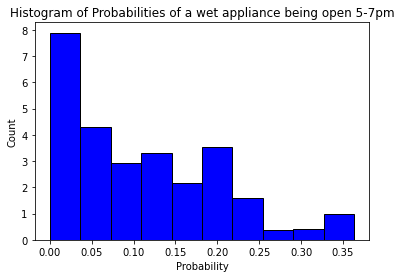

In [60]:
# Import the libraries
import matplotlib.pyplot as plt
import seaborn as sns

print(len(p))

# matplotlib histogram
plt.hist(prob_hist, color = 'blue', edgecolor = 'black',density=True)



# Add labels
plt.title('Histogram of Probabilities of a wet appliance being open 5-7pm')
plt.xlabel('Probability')
plt.ylabel('Count')

In [65]:
len(messages)

171

In [53]:
len(prob_hist)

3420

In [61]:
# seaborn histogram
sns.distplot(prob_hist, norm_hist=True)

[0.003066572379334206,
 0.19943697796164195,
 0.10136592713916595,
 8.244406466534596e-07,
 0.15116062691479232,
 0.019492864568149616,
 0.19474008073688498,
 0.011901048548417312,
 0.10597139338151296,
 0.3452105410059272,
 0.028429521012794536,
 0.24063604405727235,
 0.0970708927780213,
 0.015304414375754126,
 0.22805615167266657,
 0.018541429945412313,
 0.13923345972456727,
 0.022106658661908214,
 0.07217642530118956,
 0.11439875978182064,
 0.0012777384913892523,
 0.12984178252711065,
 0.14078600991550827,
 2.061101616633649e-06,
 0.19682373296196917,
 0.03384177876414864,
 0.14947155319717048,
 0.006524697669088439,
 0.19066822672810096,
 0.3595943135478408,
 0.011845633755331056,
 0.23673684889893692,
 0.1454045052214563,
 0.06376839323230885,
 0.19796540943807864,
 0.038627979052942324,
 0.08057491882208756,
 0.04605553887897544,
 0.07035210231003594,
 0.12617510270053744,
 0.0012777384913892523,
 0.19476267379066597,
 0.14958513553522754,
 2.404618552739257e-06,
 0.1574589863695

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

from scipy import interp
from sklearn.metrics import roc_auc_score

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(states, randprobs)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
d = { 'real': states, 'probs': randprobs }
roc_df = pd.DataFrame(d)
roc_df.to_csv('demo.csv')

In [19]:
l = [True, False, True]
[int(a) for a in l]

[1, 0, 1]